In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional, GlobalMaxPool1D, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.initializers import Constant
from nltk.tokenize import word_tokenize

In [3]:
#Cargamos dataset train en un dataframe
tweets_train = pd.read_csv('Dataset/train.csv')
tweets_test = pd.read_csv('Dataset/test.csv')
tweets_submission = pd.read_csv('Dataset/sample_submission.csv') 

In [4]:
tweets_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
#Eliminamos los emojis del texto
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Almacenamos el texto limpio en una nueva feature del dataframe
tweets_train['cleaned_text']=tweets_train['text'].apply(lambda x: remove_emoji(x))
tweets_test['cleaned_text']=tweets_test['text'].apply(lambda x: remove_emoji(x))

In [6]:
#Eliminamos los numeros, url, simbolos y signos de puntuacion del texto 
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
tweets_train['cleaned_text'] = tweets_train['cleaned_text'].apply(lambda x: clean_text(x))
tweets_test['cleaned_text'] = tweets_test['cleaned_text'].apply(lambda x: clean_text(x))

In [8]:
train_text_emb = tweets_train.cleaned_text
test_emb = tweets_test.cleaned_text
train_target_emb = tweets_train.target

In [9]:
#Tokenizer 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_text_emb)
vocab_length = len(word_tokenizer.word_index) + 1

In [10]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [11]:
longest_train = max(train_text_emb, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train_text_emb), length_long_sentence, padding='post')
test_sentences = pad_sequences(embed(test_emb), length_long_sentence, padding='post')

In [12]:
y = np.asarray(train_target_emb)

In [13]:
#Separamos al dataset tweets_train en un set de entrenamiento y uno de validacion, para text y para target
#El tamaño del set de validacion es del 25% del original
xTrain, xVal, yTrain, yVal = train_test_split(padded_sentences, y, test_size=0.25)

In [14]:
#GloVe
#Creacion de diccionario de palabras a partir del archivo preentrenado de GloVe
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('Dataset/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
#Creacion de matriz de ocurrencias de palabras que se encuentran en los textos de los tweets
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
#Modelo de capas secuencial con BLSTM
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    #CNN
    model.add(Conv1D(filters=32,kernel_size=8, activation='relu', padding="valid", strides = 1))
    model.add(MaxPool1D(pool_size=4))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(xTrain,yTrain,epochs=10,batch_size=32, validation_data=(xVal, yVal), verbose = 1, callbacks = [checkpoint, reduce_lr])

Epoch 1/10
177/179 [============================>.] - ETA: 0s - loss: 0.6642 - accuracy: 0.6921
Epoch 00001: val_loss improved from inf to 0.62523, saving model to model.h5
179/179 [==============================] - 4s 25ms/step - loss: 0.6630 - accuracy: 0.6935 - val_loss: 0.6252 - val_accuracy: 0.6318
Epoch 2/10
177/179 [============================>.] - ETA: 0s - loss: 0.5155 - accuracy: 0.7761
Epoch 00002: val_loss improved from 0.62523 to 0.52353, saving model to model.h5
179/179 [==============================] - 4s 21ms/step - loss: 0.5144 - accuracy: 0.7767 - val_loss: 0.5235 - val_accuracy: 0.7857
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8236
Epoch 00003: val_loss improved from 0.52353 to 0.44337, saving model to model.h5
179/179 [==============================] - 4s 22ms/step - loss: 0.4274 - accuracy: 0.8236 - val_loss: 0.4434 - val_accuracy: 0.8025
Epoch 4/10
177/179 [============================>.] - ETA: 0s - loss: 0.3734 

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 31, 100)           1683400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 32)            25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 32)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 62)             15872     
_________________________________________________________________
global_max_pooling1d (Global (None, 62)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62)                248       
_________________________________________________________________
dropout (Dropout)            (None, 62)               

In [23]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch ',fontsize=16)
        ax[idx].set_ylabel('Value',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

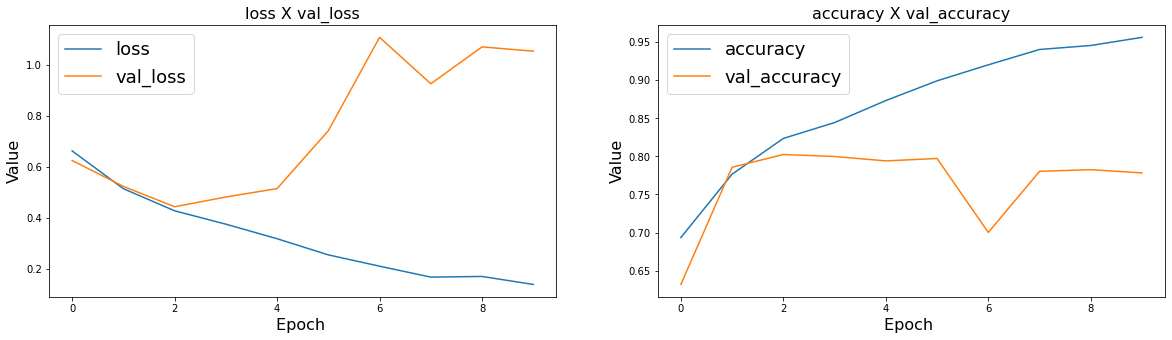

In [24]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [25]:
model.load_weights('model.h5')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


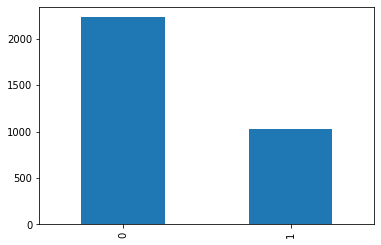

In [26]:
plt.figure(figsize=(10,7))
g = sns.barplot(x= tweets_submission.target.value_counts().index, y= tweets_submission.target.value_counts().values, orient='v', palette= 'husl', hue= tweets_submission.target.value_counts().index, dodge=False)
g.set_title("Tweets Test", fontsize=22)
g.set_xlabel("Tipo de noticia", fontsize=16)
g.set_ylabel("Cantidad de tweets", fontsize=16)

In [ ]:
tweets_submission.target = model.predict_classes(test_sentences)
tweets_submission.to_csv("submission.csv", index=False)